In [1]:
import pandas as pd
import numpy as np
import scipy.io as sio
import os
import re
import matplotlib.pyplot as plt
import source.transform_data as trs
from pathlib import Path
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering 
from sklearn.cluster import KMeans 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [2]:
path_to_data = Path('Data')

In [3]:
data_wide = pd.read_csv(path_to_data/'data_table_wide.csv', index_col=None)

In [4]:
data_wide.head()

,file_name,subject,exp_phase_id,exp_phase_descr,exp_phase_one_hot,time_stamps,time_stamps_hours,morning_afternoon,WB_time,Ngait_cycles,cadence_mean,speed_mean,speed_std,slength_mean,slength_std,gtime_mean,gtime_std,speed_CV,slength_CV,gtime_CV
0,Sub_01_locomotion_metrics_T2.mat,Sub_01,T2,Control phase: before rehab training.,0,2446.175,0.679493,1,13.620,5,90.052297,0.114202,0.165721,0.328005,0.468925,2.672000,1.991565,145.112442,142.962864,74.534631
1,Sub_01_locomotion_metrics_T2.mat,Sub_01,T2,Control phase: before rehab training.,0,2591.750,0.719931,1,7.375,5,103.294641,0.151023,0.091897,0.187907,0.121712,1.404000,0.694122,60.849881,64.772713,49.438871
2,Sub_01_locomotion_metrics_T2.mat,Sub_01,T2,Control phase: before rehab training.,0,4369.050,1.213625,1,15.795,6,52.500305,0.280798,0.048643,0.677725,0.151779,2.548333,0.736347,17.322989,22.395437,28.895232
3,Sub_01_locomotion_metrics_T2.mat,Sub_01,T2,Control phase: before rehab training.,0,4397.700,1.221583,1,33.805,15,61.260436,0.285874,0.116798,0.606137,0.250215,2.239333,0.723454,40.856607,41.280249,32.306655
4,Sub_01_locomotion_metrics_T2.mat,Sub_01,T2,Control phase: before rehab training.,0,4441.550,1.233764,1,11.875,5,58.469707,0.274018,0.064256,0.566209,0.224203,2.258000,0.676042,23.449770,39.597273,29.939849


### Number of walking bouts before vs after rehab:

In [5]:
data_wide.value_counts('exp_phase_id')

exp_phase_id
T2    31796
T3    25828
Name: count, dtype: int64

In [6]:
data_wide.value_counts('exp_phase_descr')

exp_phase_descr
Control phase: before rehab training.    31796
Test phase: after rehab training.        25828
Name: count, dtype: int64

### It looks like most people stopped recording after 8 hours:

Text(0, 0.5, 'mean speed during walking bout')

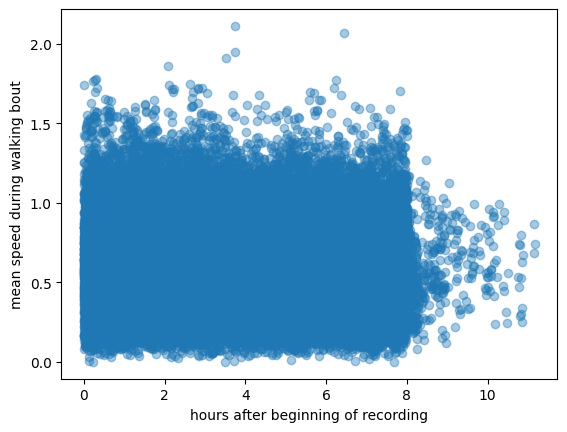

In [13]:
ax = plt.subplot()
scatter = ax.scatter(data_wide.time_stamps_hours, data_wide.speed_mean, alpha=0.4)
ax.set_xlabel("hours after beginning of recording")
ax.set_ylabel("mean speed during walking bout")

#### Is it appropriate to only consider walking bouts within 8 hours and disregard later walking bouts? If so, we could subdivide the 8 hours or recording into two phases of 4 hours each (morning and afternoon).

In [8]:
data_wide

,file_name,subject,exp_phase_id,exp_phase_descr,exp_phase_one_hot,time_stamps,time_stamps_hours,morning_afternoon,WB_time,Ngait_cycles,cadence_mean,speed_mean,speed_std,slength_mean,slength_std,gtime_mean,gtime_std,speed_CV,slength_CV,gtime_CV
0,Sub_01_locomotion_metrics_T2.mat,Sub_01,T2,Control phase: before rehab training.,0,2446.175,0.679493,1,13.620,5,90.052297,0.114202,0.165721,0.328005,0.468925,2.672000,1.991565,145.112442,142.962864,74.534631
1,Sub_01_locomotion_metrics_T2.mat,Sub_01,T2,Control phase: before rehab training.,0,2591.750,0.719931,1,7.375,5,103.294641,0.151023,0.091897,0.187907,0.121712,1.404000,0.694122,60.849881,64.772713,49.438871
2,Sub_01_locomotion_metrics_T2.mat,Sub_01,T2,Control phase: before rehab training.,0,4369.050,1.213625,1,15.795,6,52.500305,0.280798,0.048643,0.677725,0.151779,2.548333,0.736347,17.322989,22.395437,28.895232
3,Sub_01_locomotion_metrics_T2.mat,Sub_01,T2,Control phase: before rehab training.,0,4397.700,1.221583,1,33.805,15,61.260436,0.285874,0.116798,0.606137,0.250215,2.239333,0.723454,40.856607,41.280249,32.306655
4,Sub_01_locomotion_metrics_T2.mat,Sub_01,T2,Control phase: before rehab training.,0,4441.550,1.233764,1,11.875,5,58.469707,0.274018,0.064256,0.566209,0.224203,2.258000,0.676042,23.449770,39.597273,29.939849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57619,Sub_52_locomotion_metrics_T3.mat,Sub_52,T3,Test phase: after rehab training.,1,26991.800,7.497722,0,64.460,43,83.497742,0.874592,0.089487,1.232190,0.090360,1.448500,0.139510,10.231872,7.333259,9.631352
57620,Sub_52_locomotion_metrics_T3.mat,Sub_52,T3,Test phase: after rehab training.,1,27077.125,7.521424,0,135.905,89,77.971501,0.701664,0.134496,1.053104,0.191841,1.551226,0.140373,19.168207,18.216726,9.049194
57621,Sub_52_locomotion_metrics_T3.mat,Sub_52,T3,Test phase: after rehab training.,1,27347.350,7.596486,0,37.175,23,86.137404,0.824266,0.239664,1.156629,0.273526,1.458250,0.308576,29.076001,23.648566,21.160706
57622,Sub_52_locomotion_metrics_T3.mat,Sub_52,T3,Test phase: after rehab training.,1,27481.525,7.633757,0,11.655,6,85.557804,0.728868,0.040250,1.063292,0.048011,1.427500,0.203899,5.522205,4.515293,14.283677


### Number of walking bouts morning vs afternoon:

In [9]:
data_wide.value_counts('morning_afternoon')

morning_afternoon
1    30478
0    27146
Name: count, dtype: int64

### Correlation matrix:

In [10]:
data_wide.head()
data_wide_for_corr = data_wide.copy()

In [11]:
data_wide_for_corr = data_wide_for_corr.drop('time_stamps', axis=1)
data_wide_for_corr = data_wide_for_corr.drop('morning_afternoon', axis=1)
data_wide_for_corr.head()

,file_name,subject,exp_phase_id,exp_phase_descr,exp_phase_one_hot,time_stamps_hours,WB_time,Ngait_cycles,cadence_mean,speed_mean,speed_std,slength_mean,slength_std,gtime_mean,gtime_std,speed_CV,slength_CV,gtime_CV
0,Sub_01_locomotion_metrics_T2.mat,Sub_01,T2,Control phase: before rehab training.,0,0.679493,13.620,5,90.052297,0.114202,0.165721,0.328005,0.468925,2.672000,1.991565,145.112442,142.962864,74.534631
1,Sub_01_locomotion_metrics_T2.mat,Sub_01,T2,Control phase: before rehab training.,0,0.719931,7.375,5,103.294641,0.151023,0.091897,0.187907,0.121712,1.404000,0.694122,60.849881,64.772713,49.438871
2,Sub_01_locomotion_metrics_T2.mat,Sub_01,T2,Control phase: before rehab training.,0,1.213625,15.795,6,52.500305,0.280798,0.048643,0.677725,0.151779,2.548333,0.736347,17.322989,22.395437,28.895232
3,Sub_01_locomotion_metrics_T2.mat,Sub_01,T2,Control phase: before rehab training.,0,1.221583,33.805,15,61.260436,0.285874,0.116798,0.606137,0.250215,2.239333,0.723454,40.856607,41.280249,32.306655
4,Sub_01_locomotion_metrics_T2.mat,Sub_01,T2,Control phase: before rehab training.,0,1.233764,11.875,5,58.469707,0.274018,0.064256,0.566209,0.224203,2.258000,0.676042,23.449770,39.597273,29.939849


<Figure size 1000x1000 with 0 Axes>

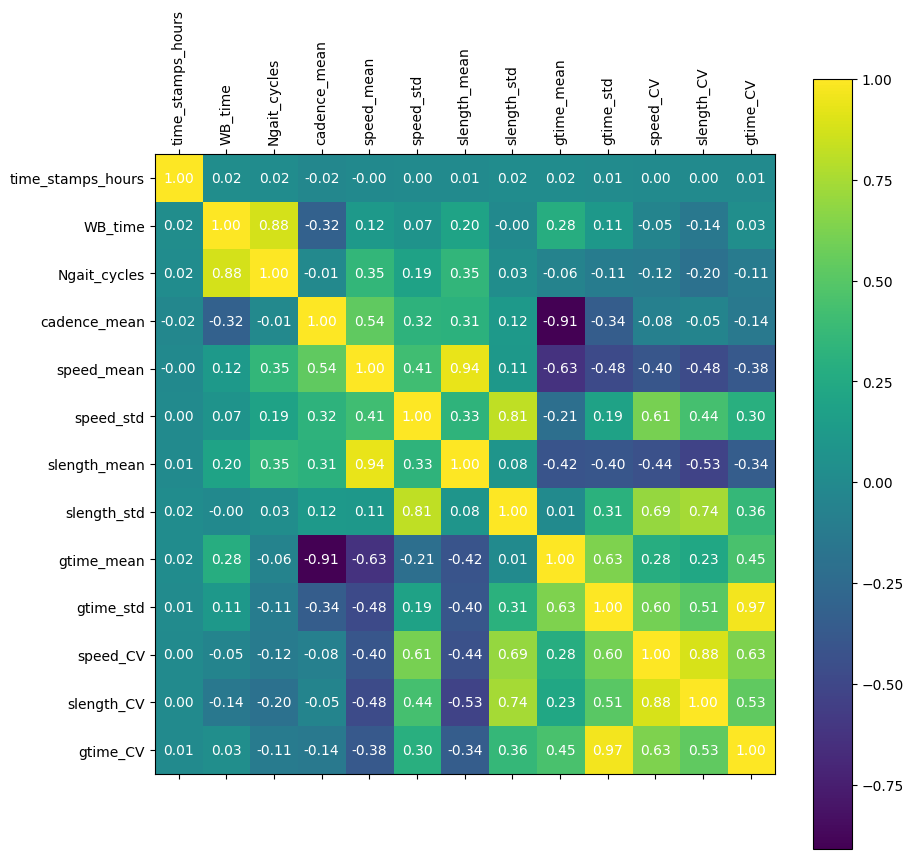

In [12]:
data_wide_num = data_wide_for_corr.iloc[:,5:].copy()

corr_matrix = data_wide_num.corr(method='spearman')

plt.figure(figsize=(10, 10))

# Create a figure and axes with the desired size
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figsize to make squares larger

# Plot the matrix using matshow on the created axes
cax = ax.matshow(corr_matrix, cmap="viridis")

# Set ticks
ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation="vertical")
ax.set_yticks(range(len(corr_matrix.columns)))
ax.set_yticklabels(corr_matrix.columns)


# Add color bar
fig.colorbar(cax)


# Add text annotations
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        ax.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha="center", va="center", color="w")

# Display the plot
plt.show()


### Frequency of walking bouts over time:

In [ ]:
data_wide.hist('time_stamps_hours')
plt.xlabel("hours after beginning of recording")
plt.ylabel("frequency of walking bouts")

### Frequency of walking bouts over time before vs after rehab:

In [ ]:
data_wide_before_rh = data_wide[data_wide.exp_phase_id == 'T2'].copy()
data_wide_after_rh = data_wide[data_wide.exp_phase_id == 'T3'].copy()

In [ ]:
data_wide_before_rh.hist('time_stamps_hours')
plt.xlabel("hours after beginning of recording")
plt.ylabel("frequency of walking bouts")
plt.title('Frequency of walking bouts before rehab:')

In [ ]:
data_wide_after_rh.hist('time_stamps_hours')
plt.xlabel("hours after beginning of recording")
plt.ylabel("frequency of walking bouts")
plt.title('Frequency of walking bouts after rehab:')

#### There seems to be a slight decrease in frequency of walking bouts over time during recording.

### More walking bouts before than after rehab: Is this possible?

In [ ]:
print(data_wide_before_rh.shape)
print(data_wide_after_rh.shape)

In [ ]:
print(len(set(data_wide_before_rh.file_name)))
print(len(set(data_wide_after_rh.file_name)))

In [ ]:
data_wide.head()

### K-means clustering to check if I stumble over anything interesting:

In [ ]:
numerical_var_names = list(data_wide.iloc[:,8:].columns)

In [ ]:
# Get the numerical variables:
numerical_variables = data_wide[numerical_var_names]
numerical_variables

#### Scale variables and put them into a numpy array:

In [ ]:
num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

In [ ]:
num_attribs = list(numerical_variables)
#cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        #("cat", OneHotEncoder(), cat_attribs),
    ])

#num_vars_prepared = full_pipeline.fit_transform(num_vars_select)
num_vars_prepared = full_pipeline.fit_transform(numerical_variables)

#### Optimal number of clusters not obvious as there is no inertia inflection point:

In [ ]:
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(num_vars_prepared)
    #kmeans.fit(numerical_variables)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3)
#kmeans.fit(num_data)
kmeans.fit(num_vars_prepared)

In [ ]:
print(num_vars_prepared.shape)
print(numerical_variables.shape)
print(data_wide.shape)

In [ ]:
data_wide_l = data_wide.copy()
data_wide_l['kmeans_labels'] = kmeans.labels_
data_wide_l_T2 = data_wide_l.loc[data_wide_l.exp_phase_id == 'T2',:]
data_wide_l_T3 = data_wide_l.loc[data_wide_l.exp_phase_id == 'T3',:]

#### Clusters do not coincide with phase of experiment (exp_phase_one_hot) and see to be equally distributed over time:

In [ ]:
index_1 = 6
index_2 = 4
index_3 = 10


print(data_wide_l.columns[index_1])
print(data_wide_l.columns[index_2])
print(data_wide_l.columns[index_3])


plt.figure(figsize=(9, 9))

#X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)

scatter = ax.scatter(data_wide_l.iloc[:, index_1], data_wide_l.iloc[:, index_2], 
           data_wide_l.iloc[:, index_3], 
           c=kmeans.labels_, cmap=plt.get_cmap("jet"), 
           marker="o")
ax.set_xlabel(data_wide_l.columns[index_1])
ax.set_ylabel(data_wide_l.columns[index_2])
ax.set_zlabel(data_wide_l.columns[index_3])
#ax.set_xticklabels([])
#ax.set_yticklabels([])
#ax.set_zticklabels([])

# produce a legend with a cross-section of sizes from the scatter
handles, labels = scatter.legend_elements()
legend2 = ax.legend(handles, labels, loc="upper right", title="Clusters")

#save_fig("preimage_plot", tight_layout=False)
plt.show()

In [ ]:
data_wide_l.columns

#### Clusters seem to be based on a somewhat trianguar shaped data distribution:

In [ ]:
index_1 = 11
index_2 = 8
index_3 = 10


print(data_wide_l.columns[index_1])
print(data_wide_l.columns[index_2])
print(data_wide_l.columns[index_3])


plt.figure(figsize=(9, 9))

#X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)

scatter = ax.scatter(data_wide_l.iloc[:, index_1], data_wide_l.iloc[:, index_2], 
           data_wide_l.iloc[:, index_3], 
           c=kmeans.labels_, cmap=plt.get_cmap("jet"), 
           marker="o")
ax.set_xlabel(data_wide_l.columns[index_1])
ax.set_ylabel(data_wide_l.columns[index_2])
ax.set_zlabel(data_wide_l.columns[index_3])
#ax.set_xticklabels([])
#ax.set_yticklabels([])
#ax.set_zticklabels([])

# produce a legend with a cross-section of sizes from the scatter
handles, labels = scatter.legend_elements()
legend2 = ax.legend(handles, labels, loc="upper right", title="Clusters")

#save_fig("preimage_plot", tight_layout=False)
plt.show()

In [ ]:
index_1 = 10
index_2 = 8
index_3 = 11


print(data_wide_l.columns[index_1])
print(data_wide_l.columns[index_2])
print(data_wide_l.columns[index_3])


plt.figure(figsize=(9, 9))

#X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)

scatter = ax.scatter(data_wide_l.iloc[:, index_1], data_wide_l.iloc[:, index_2], 
           data_wide_l.iloc[:, index_3], 
           c=kmeans.labels_, cmap=plt.get_cmap("jet"), 
           marker="o")
ax.set_xlabel(data_wide_l.columns[index_1])
ax.set_ylabel(data_wide_l.columns[index_2])
ax.set_zlabel(data_wide_l.columns[index_3])
#ax.set_xticklabels([])
#ax.set_yticklabels([])
#ax.set_zticklabels([])

# produce a legend with a cross-section of sizes from the scatter
handles, labels = scatter.legend_elements()
legend2 = ax.legend(handles, labels, loc="upper right", title="Clusters")

#save_fig("preimage_plot", tight_layout=False)
plt.show()

#### The data shape reflects the fact that walking time varies most at a particular mean cadence and stride length standard deviation:

In [ ]:
ax = plt.subplot()
scatter = ax.scatter(data_wide_l.cadence_mean, data_wide_l.WB_time, alpha=0.4,
          c=data_wide_l.kmeans_labels, cmap=plt.get_cmap("jet"))
# produce a legend with a cross-section of sizes from the scatter
handles, labels = scatter.legend_elements()
legend2 = ax.legend(handles, labels, loc="upper right", title="Clusters")
ax.set_xlabel("cadence_mean")
ax.set_ylabel("WB_time")

In [ ]:
ax = plt.subplot()
scatter = ax.scatter(data_wide_l.slength_std, data_wide_l.WB_time, alpha=0.4,
          c=data_wide_l.kmeans_labels, cmap=plt.get_cmap("jet"))
# produce a legend with a cross-section of sizes from the scatter
handles, labels = scatter.legend_elements()
legend2 = ax.legend(handles, labels, loc="upper right", title="Clusters")
ax.set_xlabel("slength_std")
ax.set_ylabel("WB_time")

#### The cluster on the right has higher mean speed values and contrary to the other two clusters seems to show correlation between mean speed and walking bout time:

In [ ]:
ax = plt.subplot()
scatter = ax.scatter(data_wide_l.speed_mean, data_wide_l.WB_time, alpha=0.4,
          c=data_wide_l.kmeans_labels, cmap=plt.get_cmap("jet"))
# produce a legend with a cross-section of sizes from the scatter
handles, labels = scatter.legend_elements()
legend2 = ax.legend(handles, labels, loc="upper right", title="Clusters")
ax.set_xlabel("speed_mean")
ax.set_ylabel("WB_time")

In [ ]:
data_wide_l.plot(kind="scatter", x="cadence_mean", y="speed_mean", alpha=0.4,
    c="kmeans_labels", cmap=plt.get_cmap("jet"), colorbar=False,
    sharex=True)

plt.show()

In [ ]:
ax = plt.subplot()
scatter = ax.scatter(data_wide_l.cadence_mean, data_wide_l.speed_mean, alpha=0.4,
          c=data_wide_l.kmeans_labels, cmap=plt.get_cmap("jet"))
# produce a legend with a cross-section of sizes from the scatter
handles, labels = scatter.legend_elements()
legend2 = ax.legend(handles, labels, loc="upper right", title="Clusters")
ax.set_xlabel("cadence_mean")
ax.set_ylabel("speed_mean")